In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from scipy.signal import find_peaks
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pyentrp.entropy as ent
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.decomposition import PCA

### Intro

I will focus on how respiration during singing changes when one sings with different postures. The dataset I am using samples a participant in the intermediate level singing a series of phrases (simple, vowel, sustained, and glissando) at increasing pitches. Then this process for the participant is repeated again over different "recording conditions" such as "hunched back" which has them perform while bent over, "sideways" in which they are leaning while singing, "low articulation" and "high articulation" in which they are told to enunciate or not, and "correct" which is the natural take with no specified instructions. During the singing clips the participants are hooked up to many sensors to gather different features, but here I will focus on the respiration monitor's data. This is taken by a piezoelectric respiration sensor using a chest belt wrapped around the diaphram, and the dataset grabs respiration data from every 30ms frame. Using this data along with the recording conditions I will focus on the following...
1) Pinpointing what qualities of respiration are influenced by bad posture
2) Can a model classify good vs bad posture using only respiration data?

### Initial Dataset Cleaning

Import dataset (downloaded locally on my computer)

In [2]:
df = pd.read_csv('Output.csv')
print (df.shape)
df.head()

(60653, 702)


,participant_number,sex,age,experience_level,phonation,recording_condition,phrase,clip_number,mic_pitch,mic_note,...,computer_face_landmark_67_x,computer_face_landmark_67_y,computer_face_landmark_67_z,computer_face_landmark_68_x,computer_face_landmark_68_y,computer_face_landmark_68_z,RESPIRATION_1,EMG_1,EEG_1,EEG_2
0,9,F,25,intermediate,breathy,correct,glissando,3,203.04004,G#3,...,1063.0,234.0,NaN,1059.0,233.0,NaN,19070,32657,29783,33826
1,9,F,25,intermediate,breathy,correct,glissando,3,206.55988,G#3,...,1063.0,234.0,NaN,1059.0,234.0,NaN,19920,32554,30375,35826
2,9,F,25,intermediate,breathy,correct,glissando,3,210.76816,G#3,...,1063.0,234.0,NaN,1059.0,234.0,NaN,20705,32792,32543,33390
3,9,F,25,intermediate,breathy,correct,glissando,3,211.93843,G#3,...,1063.0,234.0,NaN,1059.0,233.0,NaN,21202,33015,34188,34910
4,9,F,25,intermediate,breathy,correct,glissando,3,210.22719,G#3,...,1063.0,234.0,NaN,1059.0,233.0,NaN,21460,32644,32725,31375


We see that there are 702 columns, here are the column titles we are working with

In [3]:
list_columns = df.columns.to_list()

for col in list_columns:
    print (col, end = '\n')

participant_number
sex
age
experience_level
phonation
recording_condition
phrase
clip_number
mic_pitch
mic_note
mic_rms_energy
mic_spec_cent
mic_spec_spread
mic_spec_skew
mic_spec_kurt
mic_spec_slope
mic_spec_decr
mic_spec_rolloff
mic_spec_flat
mic_spec_crest
mic_tristimulus1
mic_tristimulus2
mic_tristimulus3
mic_mfcc_1
mic_mfcc_2
mic_mfcc_3
mic_mfcc_4
mic_mfcc_5
mic_mfcc_6
mic_mfcc_7
mic_mfcc_8
mic_mfcc_9
mic_mfcc_10
mic_mfcc_11
mic_mfcc_12
mic_mfcc_13
computer_pitch
computer_note
computer_rms_energy
computer_spec_cent
computer_spec_spread
computer_spec_skew
computer_spec_kurt
computer_spec_slope
computer_spec_decr
computer_spec_rolloff
computer_spec_flat
computer_spec_crest
computer_tristimulus1
computer_tristimulus2
computer_tristimulus3
computer_mfcc_1
computer_mfcc_2
computer_mfcc_3
computer_mfcc_4
computer_mfcc_5
computer_mfcc_6
computer_mfcc_7
computer_mfcc_8
computer_mfcc_9
computer_mfcc_10
computer_mfcc_11
computer_mfcc_12
computer_mfcc_13
phone_pitch
phone_note
phone_rms_ener

See how many null values there are in the dataset

In [4]:
total_null_values = df.isnull().sum().sum()
print(f"Total number of null values in the dataset: {total_null_values}")

pct_null = total_null_values/(df.shape[0] * df.shape[1]) * 100
print (f'This is {pct_null} % of all values')

Total number of null values in the dataset: 8708202
This is 20.452155959055865 % of all values


Upon inspection, noticed that all the landmark values for the z direction are missing data and have null for the entire column BESIDES phone pose and computer pose. So I will delete these columns and ensure there are fewer null values.

In [5]:
bad_cols = []

for col in list_columns:
    if col[-1] == 'z' and not 'pose' in col:
        bad_cols.append(col)

df = df.drop(columns=bad_cols)

total_null_values = df.isnull().sum().sum()
print(f"Total number of null values in the dataset: {total_null_values}")

pct_null = total_null_values/(df.shape[0] * df.shape[1]) * 100
print (f'This is {pct_null} % of all values')

Total number of null values in the dataset: 459394
This is 1.3381863661788291 % of all values


Creating a "Frame" Column

We want to be able to track each phrase from the singer. The phrase is indicated by a switch in the clip number. For example the entirety of the first simple phrase has clip number of 1, and then when it moves on to the next phrase (a pitch higher) it switches to clip 2.

In [6]:

def create_frame (array_name):
    '''
    takes in an array of clip numbers and outputs an array the same length of the corresponding frames
    '''
    last_clip = 0
    current_clip = 0
    frames = []
    frame_track = 0

    for clip in array_name:
        current_clip = clip
        if current_clip != last_clip:
            frame_track = 0
        frames.append(frame_track)
        frame_track +=1
        last_clip = current_clip

    return frames
    

In [7]:
#test frame functionality

test_array = np.array([1,1,1,2,3,3,3,4,4,4,4,4])

test_frames = create_frame(test_array)

print (test_frames)

[0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 3, 4]


In [8]:
column_vector = df['clip_number'].to_numpy()

#apply function to create a new frame column
frames = create_frame(column_vector)

In [9]:
df['frame'] = frames

#check frame column in dataset
df

,participant_number,sex,age,experience_level,phonation,recording_condition,phrase,clip_number,mic_pitch,mic_note,...,computer_face_landmark_66_y,computer_face_landmark_67_x,computer_face_landmark_67_y,computer_face_landmark_68_x,computer_face_landmark_68_y,RESPIRATION_1,EMG_1,EEG_1,EEG_2,frame
0,9,F,25,intermediate,breathy,correct,glissando,3,203.04004,G#3,...,233.0,1063.0,234.0,1059.0,233.0,19070,32657,29783,33826,0
1,9,F,25,intermediate,breathy,correct,glissando,3,206.55988,G#3,...,233.0,1063.0,234.0,1059.0,234.0,19920,32554,30375,35826,1
2,9,F,25,intermediate,breathy,correct,glissando,3,210.76816,G#3,...,233.0,1063.0,234.0,1059.0,234.0,20705,32792,32543,33390,2
3,9,F,25,intermediate,breathy,correct,glissando,3,211.93843,G#3,...,233.0,1063.0,234.0,1059.0,233.0,21202,33015,34188,34910,3
4,9,F,25,intermediate,breathy,correct,glissando,3,210.22719,G#3,...,233.0,1063.0,234.0,1059.0,233.0,21460,32644,32725,31375,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60648,9,F,25,intermediate,breathy,low_articulation,sustained,9,272.94168,C#4,...,521.0,635.0,521.0,631.0,521.0,45712,32623,31058,34270,106
60649,9,F,25,intermediate,breathy,low_articulation,sustained,9,271.00055,C#4,...,521.0,633.0,523.0,629.0,522.0,45588,32541,28622,34103,107
60650,9,F,25,intermediate,breathy,low_articulation,sustained,9,271.72437,C#4,...,521.0,633.0,522.0,629.0,521.0,45112,32942,33766,33813,108
60651,9,F,25,intermediate,breathy,low_articulation,sustained,9,274.05322,C#4,...,521.0,633.0,522.0,629.0,521.0,44744,32607,34260,35552,109


# Classifying recording position based on respiration

Now we move on to our classification problem. First, create a new dataset with the features we are interested in which are respiration, frame, and recording condition

In [10]:
#select only columns we are interested in
df1 = df[['RESPIRATION_1', "frame", 'recording_condition']]

#rename for simplicity
df1 = df1.rename(columns = {'RESPIRATION_1': 'respiration', 'recording_condition': 'condition'})
df1

,respiration,frame,condition
0,19070,0,correct
1,19920,1,correct
2,20705,2,correct
3,21202,3,correct
4,21460,4,correct
...,...,...,...
60648,45712,106,low_articulation
60649,45588,107,low_articulation
60650,45112,108,low_articulation
60651,44744,109,low_articulation


Our first approach in interpreting the respiration data is to pull out a vector of the respiration data for each phrase. Note that because the length of singing could be different each time a phrase is sung because it was on the participant's own timing, the respiration vectors may be differing lengths. We can tell where each phrase begins and ends using the frame column, because whenever there is a 0 we have restarted a new phrase.

The following code pulls out a list called vectors, and in this list it contains a vector of respiration data corresponding to each phrase in the table.

In [11]:
frame_np = df1['frame'].to_numpy()
resp_np = df1['respiration'].to_numpy()
vectors = []
vector = []

for index, frame in enumerate (frame_np):
    
    #if starting a new clip append previous clip's filled vector of resp data
    if frame == 0 and vector:
        vectors.append(vector)
        vector = []
    vector.append(resp_np[index])

#append last clip resp data (if non empty)
if vector:
    vectors.append(vector)

#print a couple of the vectors as a test
print (vectors[0])
print (vectors[1])


[19070, 19920, 20705, 21202, 21460, 21732, 22362, 23424, 24352, 25122, 25980, 27056, 28086, 29220, 30472, 31909, 33176, 34596, 36280, 37940, 39500, 41052, 42768, 43904, 44764, 45336, 45468, 45466, 45372, 45424, 45658, 45712, 45860, 46060, 46284, 46492, 46744, 46860, 46756, 46510, 46136, 45852, 45568, 45252, 44740, 44184, 43876, 43836, 43660, 43328, 43420, 43436, 43504, 43624, 43696, 43638, 43482, 43208, 43057, 43112, 43388, 43840, 44292, 44556, 44748, 44687, 44572, 44608, 44524, 44464, 44516, 44464, 44648, 45060, 45256, 45420, 45776, 46202, 46812, 47600, 48384, 49240, 50068, 50860, 51632, 52320, 52916, 53282, 53488, 53516, 53396, 53184, 52996, 52792, 52504, 52464, 52638, 52564, 52272, 51760, 51302, 51060, 50708, 50292, 49988, 49740, 49732, 49512, 48896, 48432, 47904, 47310, 46992, 46796, 46600, 46364, 46064, 45810, 45770, 45864, 45828, 45676, 45620, 45452, 44948, 44679, 44252, 43716, 43232, 42520, 41576, 39680, 37792, 35628, 33024, 30096, 27170, 24532, 22688, 21332, 20556, 20352, 20236

### Pulling out basic qualities of the respiration vectors

Now that we have our respiration data for each phrase in vector form, we will pull out basic qualities of these respiration vectors. Our first attempt is to create a basic statistical summary for each: mean, min, max, var, std dev, range (max - min). Once we have a bunch of qualities for each vector, we will eventually create a new dataframe with these as features.

In [12]:
#mean respiration for each note
mean_resp = []
for vector in vectors:
    mean_resp.append(np.mean(vector))
    
#min respiration for each note
min_resp = []
for vector in vectors:
    min_resp.append(np.min(vector))
    
#max respiration for each note
max_resp = []
for vector in vectors:
    max_resp.append(np.max(vector))
    
#variance of respiration for each note
var_resp = []
for vector in vectors:
    var_resp.append(np.var(vector))

#standard dev of respiration for each note
std_resp = []
for vector in vectors:
    std_resp.append(np.std(vector))

#range from max to min
range_resp = []
for i in range(len(max_resp)):
    range_resp.append(max_resp[i] - min_resp[i])



We will also grab some percentiles so that we have an idea of the progression of the respiration throughout the cip. The first percentiles are sorted (ie the lowest 10% up to the highest 90%), the second is just based on index (ie the 10% index place to the 90% index place).

In [13]:
#initialize lists
ten_perc = []
twenty_perc = []
thirty_perc = []
forty_perc = []
median = []
sixty_perc = []
seventy_perc = []
eighty_perc = []
ninety_perc = []

percentiles = [ten_perc, twenty_perc, thirty_perc, forty_perc, median, sixty_perc, seventy_perc, eighty_perc, ninety_perc]

#fill in percentile lists
value = 10
for percentile in percentiles:
    for vector in vectors:
        percentile.append(np.percentile(vector, value))
    value+=10

#initialize lists
ten_index = []
twenty_index = []
thirty_index = []
forty_index = []
fifty_index = []
sixty_index = []
seventy_index = []
eighty_index = []
ninety_index = []

index_percentiles = [ten_index, twenty_index, thirty_index, forty_index, fifty_index, sixty_index, seventy_index, eighty_index, ninety_index]

#fill in index percentile lists
for i in range (1,10):
    for vector in vectors:
        place = round(len(vector)/10) * i
        index_percentiles[i-1].append(vector[place])
        


### Advanced Qualities

I researched a little bit on how bad posture affects respiration to try to pull out some more helpful statistics specific to this task.

One notable thing is that the respiration peaks might be affected by bad posture, since many sources indicate constricted position should lead to lower amplitude and shorter breaths. I will pull out each phrase's biggest peak and it's height, width, and "prominence", as well as how many detected peaks there were using the find_peaks algorithm.

In [14]:
peak_prominence = []
peak_height = []
peak_width = []


for vector in vectors:
    
    #peak data
    peaks, properties = find_peaks(vector, prominence = 0, height = 0, width = 0)

    
    #pull out only the most prominent peak and trough for each clip
    max_index = np.argmax(properties['prominences'])
    
    #peak qualities
    peak_prominence.append((properties['prominences'])[max_index])
    peak_height.append((properties['peak_heights'])[max_index])
    peak_width.append((properties['widths'])[max_index])
    

Measure the root mean squared (RMS) of the respiration, another indication of how shallow/deep the breathing is

In [15]:
rms = []

for vector in vectors:
    squared_resp = []
    
    for val in vector:
        squared_resp.append(val**2)
    
    rms.append(np.sqrt(np.mean(squared_resp)))
    

Entropy measures the complexity/randomness of the data. I will use the pyEntropy library and use the sample entropy function to get a measure for the "regularness" of each phrase's data, higher values indicate more irregular breathing pattern.

In [16]:
entropy = []

for vector in vectors:
    
    m = 2    #typically set to 2 for sample entropy, compares each two neighboring points
    r = 0.2*np.std(vector)   #typically set to 0.2 times standard dev of the vector
    
    entropy.append(ent.sample_entropy(vector,m,r)[1]) #pull out data for m=2


### Append these features to the dataframe

Since we only need one row per phrase (all our columns are some kind of compilation of the respiration data from each phrase into one value), I will just take the rows that have frame = 0

In [17]:
df1 = df1[df1['frame']==0]

print ('check that we now have same number of rows in data frame as respiration vectors:')
print (df1.shape[0] == len(vectors))

#no longer need respiration or frame columns
df1 = df1.drop(columns =['frame', 'respiration'])

check that we now have same number of rows in data frame as respiration vectors:
True


Append all of our new information as new columns

In [18]:
import warnings
warnings.filterwarnings('ignore')

df1['mean'] = mean_resp
df1['min'] = min_resp
df1['max'] = max_resp
df1['variance'] = var_resp
df1['std dev'] = std_resp
df1['range'] = range_resp

df1['10th percentile'] = percentiles[0]
df1['20th percentile'] = percentiles[1]
df1['30th percentile'] = percentiles[2]
df1['40th percentile'] = percentiles[3]
df1['Median'] = percentiles[4]
df1['60th percentile'] = percentiles[5]
df1['70th percentile'] = percentiles[6]
df1['80th percentile'] = percentiles[7]
df1['90th percentile'] = percentiles[8]

df1['10th index'] = index_percentiles[0]
df1['20th index'] = index_percentiles[1]
df1['30th index'] = index_percentiles[2]
df1['40th index'] = index_percentiles[3]
df1['50th index'] = index_percentiles[4]
df1['60th index'] = index_percentiles[5]
df1['70th index'] = index_percentiles[6]
df1['80th index'] = index_percentiles[7]
df1['90th index'] = index_percentiles[8]

df1['peak prominence'] = peak_prominence
df1['peak height'] = peak_height
df1['peak width'] = peak_width

df1['rms'] = rms
df1['entropy'] = entropy

#check how dataframe looks now
df1

,condition,mean,min,max,variance,std dev,range,10th percentile,20th percentile,30th percentile,...,50th index,60th index,70th index,80th index,90th index,peak prominence,peak height,peak width,rms,entropy
0,correct,41073.873333,15016,53516,1.084615e+08,10414.487038,38500,21447.2,31621.6,43095.5,...,45420,53396,49740,45828,30096,34446.0,53516.0,114.684867,42373.631079,0.105361
150,correct,39703.264286,8457,58028,2.305832e+08,15184.967362,49571,18371.4,24728.0,31472.4,...,56152,54700,57784,51692,16548,39454.0,58028.0,72.050905,42508.027815,0.161593
290,correct,39694.696970,21460,49384,5.750252e+07,7583.041511,27924,29773.0,31878.8,35639.2,...,43052,49040,44840,44116,32336,19618.0,49384.0,78.977341,40412.516453,0.236295
422,correct,42870.058824,9396,59260,1.517670e+08,12319.374658,49864,25948.0,30971.2,36732.6,...,52976,57280,56480,50388,47860,36319.0,59260.0,91.912312,44605.032625,0.161155
575,correct,35499.049296,17496,50840,9.579919e+07,9787.705900,33344,22024.2,22665.6,29905.4,...,38540,42132,44450,47824,46436,29296.0,50840.0,81.138266,36823.656631,0.177428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60101,low_articulation,31801.086207,14734,50432,1.217325e+08,11033.244678,35698,16256.0,19745.0,21848.0,...,50424,43420,37408,35272,34372,16060.0,50432.0,21.059521,33660.682882,0.118137
60217,low_articulation,30794.828829,23804,50900,4.637015e+07,6809.563216,27096,24410.0,25036.0,25572.0,...,41296,40676,32280,28268,25483,18309.0,43792.0,21.455068,31538.732279,0.178463
60328,low_articulation,37623.805825,21493,46900,4.385773e+07,6622.516754,25407,26228.8,33083.2,36428.0,...,39500,46836,43952,42132,40472,11336.0,46900.0,35.673034,38202.205341,0.272894
60431,low_articulation,42396.288288,23054,53564,7.137167e+07,8448.175275,30510,28112.0,32100.0,42836.0,...,50296,46310,44364,42836,43592,10888.0,53564.0,28.057253,43229.815245,0.128061


### Determine what to classify

Now that we have our dataframe, we look into what exactly we want our target column to be. I decided to start by classifying correct posture by using the correct and high articulation conditions vs incorrect posture that takes the sideways or hunched back positions. Notice I chose the most logical 2 recording conditions for each so that there would be a relatively even split between correct and incorrect to model off of.

In [19]:
#will use later
df_save_copy = df1.copy()

#select only the conditions we are interested in
df1 = df1[(df1['condition'] == 'hunched_back') | (df1['condition'] == 'correct') | (df1['condition'] == 'sideways') | (df1['condition'] == 'high_articulation')]
    
good_posture = ['correct', 'high_articulation']

def check_posture(position):
    '''
    takes in a string of recording condition 
    and outputs whether it is correct posture or incorrect in a string
    '''
    if position in (good_posture):
        return 'correct'
    else: return 'incorrect'

#create a new column called posture that contains the correct or incorrect
df1['posture'] = df1['condition'].apply(check_posture)


#posture replaces condition column
df1 = df1.drop(columns =['condition'])

#output final respiration dataset to work with
df1

,mean,min,max,variance,std dev,range,10th percentile,20th percentile,30th percentile,40th percentile,...,60th index,70th index,80th index,90th index,peak prominence,peak height,peak width,rms,entropy,posture
0,41073.873333,15016,53516,1.084615e+08,10414.487038,38500,21447.2,31621.6,43095.5,43838.4,...,53396,49740,45828,30096,34446.0,53516.0,114.684867,42373.631079,0.105361,correct
150,39703.264286,8457,58028,2.305832e+08,15184.967362,49571,18371.4,24728.0,31472.4,38023.2,...,54700,57784,51692,16548,39454.0,58028.0,72.050905,42508.027815,0.161593,correct
290,39694.696970,21460,49384,5.750252e+07,7583.041511,27924,29773.0,31878.8,35639.2,39673.6,...,49040,44840,44116,32336,19618.0,49384.0,78.977341,40412.516453,0.236295,correct
422,42870.058824,9396,59260,1.517670e+08,12319.374658,49864,25948.0,30971.2,36732.6,41240.0,...,57280,56480,50388,47860,36319.0,59260.0,91.912312,44605.032625,0.161155,correct
575,35499.049296,17496,50840,9.579919e+07,9787.705900,33344,22024.2,22665.6,29905.4,33203.2,...,42132,44450,47824,46436,29296.0,50840.0,81.138266,36823.656631,0.177428,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56091,47224.593750,23150,57824,6.904036e+07,8309.052894,34674,33734.0,42036.0,44130.0,47052.0,...,48424,56904,44672,28844,17344.0,57824.0,13.212055,47950.001198,0.366901,correct
56187,36555.627660,18324,47008,4.500031e+07,6708.227172,28684,25270.8,32146.4,36261.0,37379.2,...,39684,37808,37456,36908,14716.0,47008.0,31.618352,37166.035911,0.280484,correct
56281,31461.888889,9934,43644,8.771535e+07,9365.647094,33710,14740.4,23709.6,29129.2,31429.2,...,38919,39372,38048,34640,12232.0,43644.0,37.500710,32826.297354,0.195146,correct
56380,31146.303371,19320,45236,4.351693e+07,6596.736332,25916,21134.4,24364.4,29736.0,30433.6,...,34820,38316,41292,31772,15128.0,45236.0,12.955072,31837.228898,0.296831,correct


Text(0, 0.5, 'count')

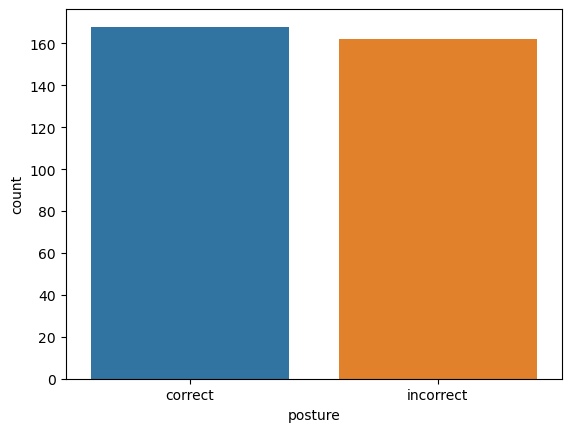

In [20]:
#ensure we have a roughly even split to classify on
posture_counts = df1['posture'].value_counts()

sns.barplot(x=posture_counts.index, y=posture_counts.values)

plt.ylabel('count')

### Visualization
Before running a model, let's explore how exactly some of these new features should relate to singing posture with visualizations. This should help answer our question of identifying what exactly changes in respiration when one sings with bad posture.

First look at mean, median, and range

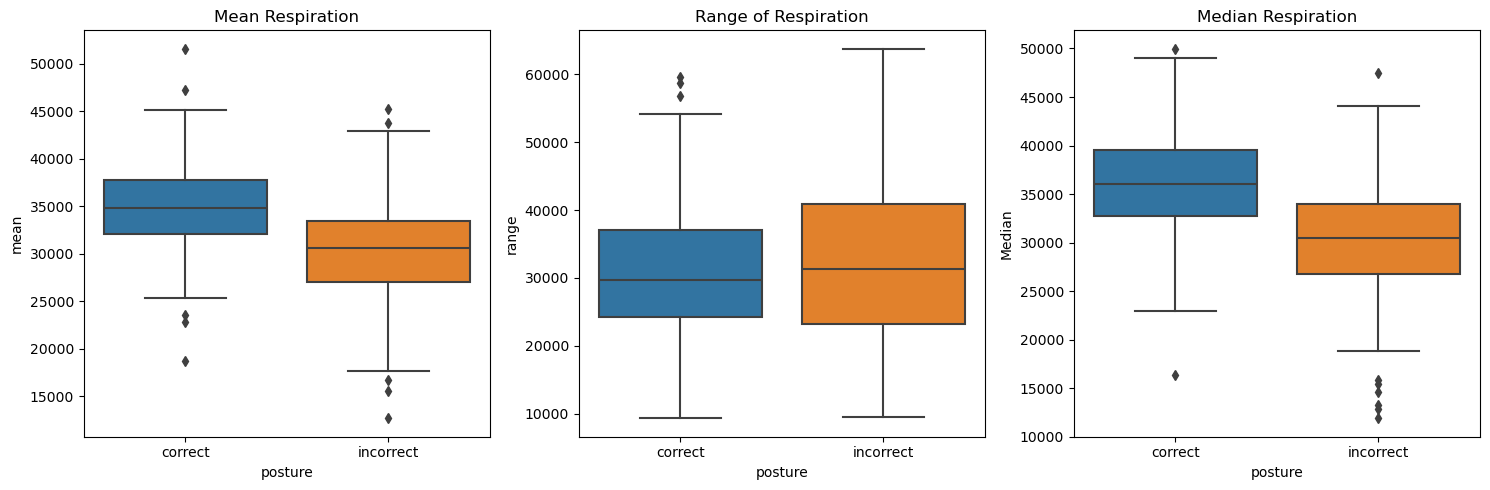

In [21]:
fig, ax = plt.subplots(ncols = 3, figsize = (15,5))

sns.boxplot(df1, x = 'posture', y = 'mean', ax= ax[0])
sns.boxplot(df1, x = 'posture', y = 'range', ax = ax[1])
sns.boxplot(df1, x = 'posture', y = 'Median', ax = ax[2])

ax[0].set_title('Mean Respiration')
ax[1].set_title('Range of Respiration')
ax[2].set_title('Median Respiration')

plt.tight_layout()

We can clearly see that both the mean and median respiration averaged over every phrase for correct posture is substantially higher than for incorrect posture. This helps support our conclusion that the incorrect posture positions lead to more shallow breaths, and lower respiration peaks.

Now explore the average pattern of respiration for correct or incorrect posture. This uses the time series data taken by the "10th index" through "90th index columns" and averaged by posture group.

In [22]:
df1_grouped = df1.groupby('posture', as_index = False).mean()

Text(0, 0.5, 'Respiration')

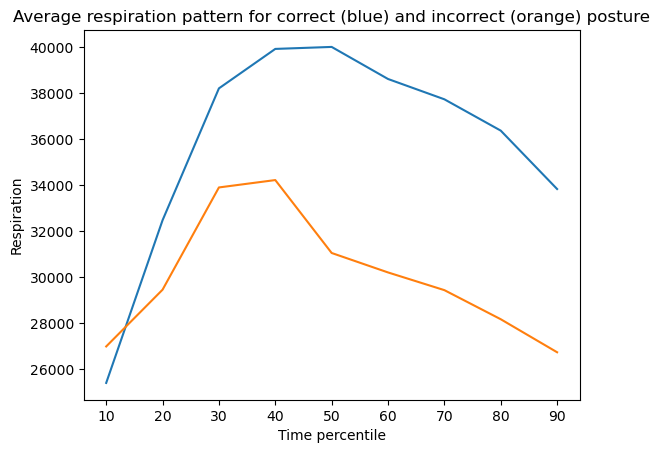

In [23]:
columns_to_select = ['10th index', '20th index', '30th index', '40th index', '50th index', '60th index',
                    '70th index', '80th index', '90th index']

#grab the data from index columns for each posture
correct_list = df1_grouped.loc[0, columns_to_select].tolist()
incorrect_list = df1_grouped.loc[1, columns_to_select].tolist()

x_axis = np.arange(10,100,10)

#create plot
sns.lineplot(x = x_axis, y = correct_list)
sns.lineplot(x = x_axis, y = incorrect_list)

#label plot
plt.title('Average respiration pattern for correct (blue) and incorrect (orange) posture')
plt.xlabel('Time percentile')
plt.ylabel('Respiration')


This graph is again a very telling conclusion beacuse it indicates that the respiration pattern for one phrase of singing for incorrect posture is at significantly lower levels than the correct pattern. The waves follow a similar shape both peaking around the 30-40th percentile, but their magnitude is very different again indicating that the hunched back and sideways postures don't allow one to reach as high of a respiration peak. 

### Running the Models

Now we will start actually training the models. First we standardize the columns and break into train test split using a 20% test size

In [24]:

#create target and feature columns
target = df1['posture']
inputs = df1.drop(columns = ['posture'])

#standardize feature columns
scaler = StandardScaler()
scaled_inputs = scaler.fit_transform(inputs)

#train test split
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, target ,test_size=0.2)

I will explore a knn model, random forest, logistic regression, and support vector machine. The model parameters are tuned using the grid search algorithm which automatically uses a 5 fold cross validation to choose optimal parameters

In [25]:
#establish parameters to choose from for each model
knn_param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

rf_param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [3, 5, 10, 20, 40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

log_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}

svm_param_grid = {
    'C': [1, 10, 100, 200], 
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['linear','rbf', 'poly']
}

def grid_search_model(model, param_grid, train_X, train_y, test_X, test_y, model_name):
    '''
    The function performs grid search to identify optimal parameters based on training data,
    evaluates this function on testing data over 5 new splits, and prints the details and accuracy
    of the best model.
    '''
    
    # set model paramaters using grid search
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', verbose = 0)
        
    # Fit the grid search
    search.fit(train_X, train_y)
    
    # Get the best parameters
    best_params = search.best_params_
    
    #Get the best model
    best_model = search.best_estimator_
    
    # Evaluate the best model on the test data
    test_accuracy = cv_accuracy(best_model, param_grid)
    
    # print parameters and scores
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print(f"Test Accuracy Averaged Over 5 Splits: {test_accuracy: .2f}")
    
    return best_model

def cv_accuracy(best_model, param_grid):
    '''
    Takes in a model with defined parameters and re-preforms train, test, split on the dataset 5 times.
    For each split, it fits the model on training data and then scores the model on testing data.
    Then, the average score from each of the splits is returned.
    '''
    scores = []
    for i in range(5):
        
        #train test split
        X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, target ,test_size=0.2)
        
        #fit model
        best_model.fit(X_train, y_train)
        
        #score model
        scores.append(best_model.score(X_test, y_test))
    
    #return average score over 5 splits
    return np.mean(scores)

#create and evaluate models using functions defined above
best_knn = grid_search_model(KNeighborsClassifier(), knn_param_grid, X_train, y_train, X_test, y_test, 'knn' )
best_rf = grid_search_model(RandomForestClassifier(), rf_param_grid, X_train, y_train, X_test, y_test, 'random forest' )
best_log = grid_search_model(LogisticRegression(), log_param_grid, X_train, y_train, X_test, y_test, 'logistic regression' )
best_svm = grid_search_model(svm.SVC(), svm_param_grid, X_train, y_train, X_test, y_test, 'svm' )




Model: knn
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Test Accuracy Averaged Over 5 Splits:  0.72
Model: random forest
Best Parameters: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'log2', 'n_estimators': 100}
Test Accuracy Averaged Over 5 Splits:  0.75
Model: logistic regression
Best Parameters: {'C': 0.001, 'max_iter': 100, 'solver': 'liblinear'}
Test Accuracy Averaged Over 5 Splits:  0.77
Model: svm
Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Test Accuracy Averaged Over 5 Splits:  0.68


These results are fairly good, just using respiration data we are able to classify the singing posture with a testing accuracy in the mid to high 70 percents using the random forest and logistic regression models and verified by cross validation. This started from a roughly even split so an untrained model should be returning about 50%, which means that our model has clearly learned and picked up on some patterns in respiration that are indicators of bad posture.

### Explore feature selection 

How does each feature contribute to the accuracy of the model?

I will use rfe for the random forest model and try different numbers of features to include, from the 3 most important up to all of them. I use cross validation of 5 folds on each scoring for better accuracy results, and I will plot these training scores in a graph

Text(0, 0.5, 'RF model training accuracy (with CV)')

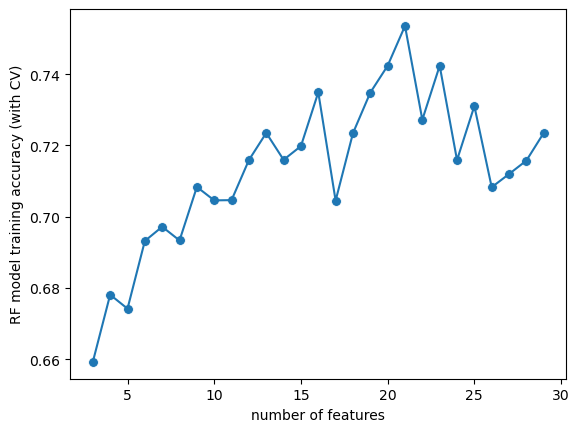

In [26]:
def run_rfe (num_features):
    '''
    run recursive feature selection with number of features input
    '''
    
    rfe_model = best_rf
    rfe = RFE(rfe_model, n_features_to_select=num_features)

    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    
    # Perform cross-validation to evaluate the model on 5 folds of training data
    cv_scores = cross_val_score(rfe_model, X_train_rfe, y_train, cv=5)

    # Return the mean accuracy from cross-validation
    return cv_scores.mean()

accuracies = []
for i in range (3,(df1.shape[1])):
    accuracies.append(run_rfe(i))

sns.lineplot(x = range (3,(df1.shape[1])), y = accuracies)
sns.scatterplot(x = range (3,(df1.shape[1])), y = accuracies, s = 50)

plt.xlabel('number of features')
plt.ylabel('RF model training accuracy (with CV)')


In [35]:
#pull out highest accuracy model details
highest_index = np.argmax(accuracies)
best_num_features = highest_index+3

print (f'Highest training accuracy was with {best_num_features} features')
print (f'This rf model had training accuracy of {accuracies[highest_index]:0.2f}')


Highest training accuracy was with 21 features
This rf model had training accuracy of 0.75


This training accuracy of mid 70 percents is similar to our previous testing accuracy, and occurs with almost all of the features included. The model does appear to rely on the majority of the features to work together to inform it's accuracy, so we shouldn't reduce to just a few dimensions

Which features were most to least helpful in informing our rf model?

In [28]:
importances = best_rf.feature_importances_

indices = np.argsort(importances)[::-1]  #sort highest to lowest

list_cols = df1.columns.to_list()

# Print feature ranking
print ('Features from most to least important:')
for i in range(X_train.shape[1]):
    print(f"{i + 1}. {list_cols[indices[i]]}: {importances[indices[i]]:0.3f}")

Features from most to least important:
1. 30th percentile: 0.055
2. 70th index: 0.053
3. Median: 0.048
4. 10th index: 0.047
5. 50th index: 0.045
6. peak width: 0.044
7. 80th index: 0.043
8. 60th index: 0.042
9. peak height: 0.042
10. 20th percentile: 0.039
11. 40th percentile: 0.038
12. 10th percentile: 0.038
13. 90th index: 0.037
14. entropy: 0.034
15. min: 0.031
16. rms: 0.029
17. max: 0.029
18. 40th index: 0.028
19. mean: 0.028
20. 80th percentile: 0.027
21. 20th index: 0.027
22. 60th percentile: 0.027
23. range: 0.026
24. variance: 0.026
25. 90th percentile: 0.026
26. peak prominence: 0.024
27. 70th percentile: 0.023
28. 30th index: 0.023
29. std dev: 0.022


### A Different Classification Problem

Now, instead of sorting between the binary "correct" vs "incorrect" posture, we will see if the model can similarly learn to pick up on what exactly is wrong with the posture. This time we will classify between correct posture, hunched back posture, and sideways posture so there should be 3 distinct categories with relatively even splits of around a third of the data in each.

Text(0, 0.5, 'count')

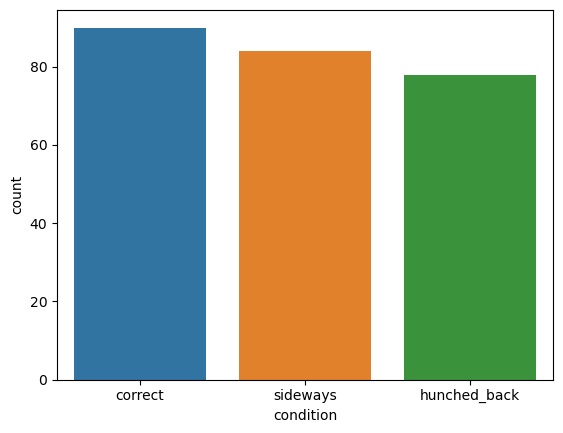

In [29]:
#saved from earlier
df2 = df_save_copy

#select only the conditions we are interested in
df2 = df2[(df2['condition'] == 'hunched_back') | (df2['condition'] == 'correct') | (df2['condition'] == 'sideways')]

#ensure we have a roughly even split to classify on
posture_counts = df2['condition'].value_counts()

sns.barplot(x=posture_counts.index, y=posture_counts.values)

plt.ylabel('count')

Now we again go through the train test split, this time just using the condition column as our target instead of creating a binary

In [30]:
#create target and feature columns
target = df2['condition']
inputs = df2.drop(columns = ['condition'])

#standardize feature columns
scaler = StandardScaler()
scaled_inputs = scaler.fit_transform(inputs)

#train test split
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, target ,test_size=0.2)

Create the four models using gridsearch, and score using cv with the funciton defined above

In [31]:
#create and evaluate models using functions defined above
best_knn = grid_search_model(KNeighborsClassifier(), knn_param_grid, X_train, y_train, X_test, y_test, 'knn' )
best_rf = grid_search_model(RandomForestClassifier(), rf_param_grid, X_train, y_train, X_test, y_test, 'random forest' )
best_log = grid_search_model(LogisticRegression(), log_param_grid, X_train, y_train, X_test, y_test, 'logistic regression' )
best_svm = grid_search_model(svm.SVC(), svm_param_grid, X_train, y_train, X_test, y_test, 'svm' )

Model: knn
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Test Accuracy Averaged Over 5 Splits:  0.64
Model: random forest
Best Parameters: {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 200}
Test Accuracy Averaged Over 5 Splits:  0.65
Model: logistic regression
Best Parameters: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Test Accuracy Averaged Over 5 Splits:  0.66
Model: svm
Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Test Accuracy Averaged Over 5 Splits:  0.72


It is expected that the testing accuracies should drop since now we are sorting into 3 groups so the untrained accuracy should be just around 33 percent. With this considered, our models actually perform fairly well reaching around a 70 percent testing accuracy with cross validation.

## Different approach to use the respiration data 

Another way to handle the respiration data is to create time series vectors for each phrase instead of just a bunch of summary qualities. Recall that each phrase has a respiration vector that can be of varying length, but contains the data from every 30 ms frame in order. If I can make these vectors all the same length then the raw data can be passed into a model to try to predict posture. I will choose length of 100 and take every 1% index of the respiration data for each phrase.

In [89]:
time_vecs = []

#take every 100th index (rounded to nearest int) from full respiration vector
for vector in vectors:
    time_series = []
    step = len(vector)/100
    
    for i in range (100):
        index = round(step*i)
        time_series.append(vector[index])
        
    time_vecs.append(time_series)

#create new dataframe with the condition and vectorized respiration data of length 100
df_time = pd.DataFrame({
    'condition': df_save_copy['condition'],
    'respiration': time_vecs
})

#again classify based on good vs bad posture and only use positions specified
#this time classify with binary 0 or 1, better for nn model than words
df_time = df_time[(df_time['condition'] == 'hunched_back') | (df_time['condition'] == 'correct') | (df_time['condition'] == 'sideways')| (df_time['condition'] == 'high_articulation')]
df_time['posture'] = df_time['condition'].apply(check_posture)
df_time['posture'] = df_time['posture'].apply(lambda x: 1 if x == 'correct' else 0)

#posture replaces condition column
df_time = df_time.drop(columns =['condition'])

#output working dataset
df_time

,respiration,posture
0,"[19070, 20705, 21202, 21460, 22362, 24352, 251...",1
150,"[18924, 18693, 18692, 19106, 20106, 21394, 231...",1
290,"[36572, 36552, 34408, 33326, 32556, 31364, 310...",1
422,"[22941, 23496, 23812, 24840, 25312, 26236, 266...",1
575,"[23204, 22896, 22458, 22440, 22448, 22176, 220...",1
...,...,...
56091,"[50184, 49654, 48500, 47052, 45730, 44820, 443...",1
56187,"[31742, 30286, 28652, 27040, 25856, 25020, 240...",1
56281,"[31498, 30340, 28552, 26160, 23716, 21348, 193...",1
56380,"[32508, 30888, 29180, 27844, 26294, 26294, 246...",1


### Neural Network for Binary Classification

For this type of dataset where one of our features is actually a vector of values in a meaningful time series, I will instead use an RNN model which should be able to pick up on patterns of the vectors. First I split and scale the data as usual, then reshape it into an array that can be properly handled by the neural network

First I will make a neural network on our first classification set up of incorrect vs correct posture

In [90]:
inputs = df_time['respiration']
target = df_time['posture']

def tts():
    '''
    perform train test split and reshape for use in rnn model
    made into a function so that I can cv with multiple splits easily later
    '''
    #train test split
    X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3)

    # Reshape inputs for RNN, first convert pandas to a list
    X_train = np.array(X_train.tolist())
    X_test = np.array(X_test.tolist()) 

    #scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1,1))
    X_test = scaler.transform(X_test.reshape(-1,1))

    # Reshape for RNN input shape (batch_size (inferred if -1), timesteps, features)
    X_train = X_train.reshape(-1, 100, 1)
    X_test = X_test.reshape(-1, 100, 1)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = tts()

Notes on my model definition:

I tuned the parameters just using trial and error, I found that the GRU type of rnn model performed the best on my data. It is a relatively simple structure with layers of 120 and 64 units that go into a binary classification. The relu activation worked best for me (since patterns are nonlinear) and I added a dropout layer because at first the testing accuracy was significantly below the training. I found that 10 epochs was slightly too short because a lot of times the model was still learning, so I am using 30.

I scored the model by splitting the data 5 new times, refitting, and evaluating for each one and averaging out the accuracy score.

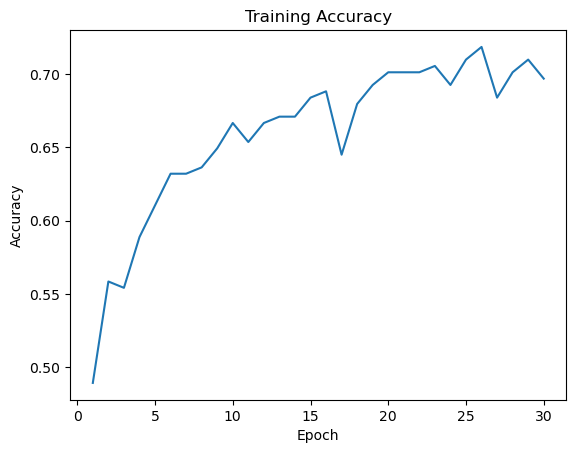

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7087 - loss: 0.5753 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7831 - loss: 0.4810  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7603 - loss: 0.5035  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7623 - loss: 0.4986  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7367 - loss: 0.5946 

Test Accuracy Averaged over 5 Splits: 0.747474753856659


In [91]:
# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(120, input_shape=(100, 1), activation = 'relu', return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#save an unfitted model to use for cv later
model_copy = tf.keras.models.clone_model(model)

# Train the model and save training accuracies as a variable
history = model.fit(X_train, y_train, epochs=30, batch_size=24, verbose = 0)
training_accuracy = history.history['accuracy']

# Plot training accuracy
epochs = np.arange(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#perform train test split 5 times and refit a fresh model each time
#evaluate testing accuracy and take average score
acc = []
for i in range (5):
    #perform train test split
    X_train, X_test, y_train, y_test = tts()
    
    #use a fresh model to avoid refitting the same one
    model_cv = tf.keras.models.clone_model(model_copy)
    model_cv.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    #fit model to new training data
    model_cv.fit(X_train, y_train, epochs=30, batch_size=24, verbose = 0)
    #score model
    _, test_acc = model_cv.evaluate(X_test, y_test)
    acc.append(test_acc)
    
print('\nTest Accuracy Averaged over 5 Splits:', np.mean(acc))

This is a pretty similar testing accuracy to the previous ML models in the mid 70 percents, which is fairly good

### Neural network for hunched back, sideways, and correct posture classification

Now we will try to do the same neural network but for our second classification setup which splits into three roughly even posture groups of hunched back, sideways and correct. For this categorical data, I will have to use one hot encoding to allow the neural network to use it

In [96]:
#create new dataframe with the condition and vectorized respiration data of length 100
df_time_2 = pd.DataFrame({
    'condition': df_save_copy['condition'],
    'respiration': time_vecs
})

#select only the three positions interested in
df_time_2 = df_time_2[(df_time_2['condition'] == 'hunched_back') | (df_time_2['condition'] == 'correct') | (df_time_2['condition'] == 'sideways')]

#identify input vs target features
inputs = df_time_2['respiration']
target = df_time_2['condition']

#perform train test split
X_train, X_test, y_train, y_test = tts()

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Fit the encoder on the training target data
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Transform the test target data
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))


I again experimented with the depth and parameters of the model, and found this structure to perform the best. This model took a lot longer to train so I upped the epochs to 50, and I again scored the testing accuracy on 5 new splits and fitting of the model to the data.

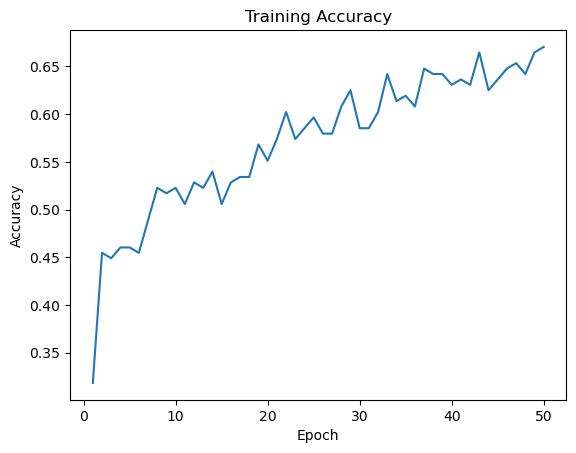

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7002 - loss: 0.7298  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6283 - loss: 1.2730 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6229 - loss: 0.8103 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6308 - loss: 0.8797 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5746 - loss: 0.8552 

Test Accuracy Averaged over 5 Splits: 0.6236842155456543


In [101]:
warnings.filterwarnings('ignore')

# Define RNN model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, input_shape=(100, 1), activation = 'relu', return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(64, activation = 'relu', return_sequences = True),
    tf.keras.layers.GRU(64, activation = 'relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer for 3 categories
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#save an unfitted model to use for cv later
model_copy = tf.keras.models.clone_model(model)

# Train the model and save training accuracies as a variable
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=24, verbose = 0)
training_accuracy = history.history['accuracy']

# Plot training accuracy
epochs = np.arange(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#perform train test split 5 times and refit a fresh model each time
#evaluate testing accuracy and take average score
acc = []
for i in range (5):
    #perform train test split
    X_train, X_test, y_train, y_test = tts()
    model_cv = tf.keras.models.clone_model(model_copy)
    model_cv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    # Fit the encoder on the training target data
    y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

    # Transform the test target data
    y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
    
    #fit the model on encoded training data
    model_cv.fit(X_train, y_train_encoded, epochs=50, batch_size=24, verbose = 0)
    
    #score the model on test data
    _, test_acc = model_cv.evaluate(X_test, y_test_encoded)
    acc.append(test_acc)
    
print('\nTest Accuracy Averaged over 5 Splits:', np.mean(acc))


This is slightly lower testing accuracy than our other machine learnin models, although compared with the original split into thirds it is clear the model has learned some patterns from the data.

### Conclusions

   The visualizations and feature selection helped us to more clearly see what exactly changes when we change singing posture. Most notably, the respiration pattern for each phrase is much lower in the hunched back or sideways positions compared with the correct posture. The two wave patters follows a very similar shape that peaks at around the 30-40 percent index and then declines, but the correct posture reaches much higher up on this respiration graph. Similarly, the mean and median are both noticably lower for the incorrect posture respiration averages. These findings indicate that a major consequence of poor posture is more shallow and less full breaths due to more constricted airways.
   
   As far as the machine learning goes, we were able to create fairly well performing models that classify correct posture vs incorrect posture using only the respiration feature. One way to do this was to pull out statistical summary values from each phrase's respiration vector such as mean, median, peaks, variance, etc. After hyperparameter tuning and feature selection the testing accuracy fell around 75% with cross validation (compared with an even split of about 50% of each category). The other way we interpreted the respiration vectors was to create a time series vector of 100 evenly spaced index places for each phrase. Then these vectors were fed into a rnn neural network model, and after playing with the complexity and number of layers the testing accuracy again fell around 75% on the unseen data. 
   
   The other style of classification was grouping into the specific types of postures "correct", "hunched back", and "sideways". The machine learning models using respiration statistical summaries were able to reach around 70% testing accuracy (compared with a roughly 33% split in each category). The neural network using time series data performed slightly worse at a low 60% testing accuracy.
   
   Although these models aren't perfectly accurate, they clearly were able to learn from the respiration and make fairly informed conclusions from the patterns found.